Epoch 0, Loss: 16.270803, gamma: 0.9900, k: 0.9900
Epoch 500, Loss: 0.170216, gamma: 0.7374, k: 1.0749
Epoch 1000, Loss: 0.153002, gamma: 0.7306, k: 1.6603
Epoch 1500, Loss: 0.138715, gamma: 0.8874, k: 2.1976
Epoch 2000, Loss: 0.121619, gamma: 1.0637, k: 2.9139
Epoch 2500, Loss: 0.104643, gamma: 1.1939, k: 3.6313
Epoch 3000, Loss: 0.098084, gamma: 1.1420, k: 3.9735
Epoch 3500, Loss: 0.131183, gamma: 1.0267, k: 4.4892
Epoch 4000, Loss: 0.074943, gamma: 1.2714, k: 5.0414
Epoch 4500, Loss: 0.071740, gamma: 1.2603, k: 5.2272
Epoch 5000, Loss: 0.070007, gamma: 1.1974, k: 5.3493
Epoch 5500, Loss: 0.495801, gamma: 1.1651, k: 5.8610
Epoch 6000, Loss: 0.057425, gamma: 1.2930, k: 6.0178
Epoch 6500, Loss: 0.059420, gamma: 1.2211, k: 6.0172
Epoch 7000, Loss: 0.050960, gamma: 1.3179, k: 6.4674
Epoch 7500, Loss: 0.051120, gamma: 1.2940, k: 6.4919
Epoch 8000, Loss: 0.060049, gamma: 1.0029, k: 6.4520
Epoch 8500, Loss: 0.045033, gamma: 1.2974, k: 6.7657
Epoch 9000, Loss: 0.042012, gamma: 1.1956, k: 6.7

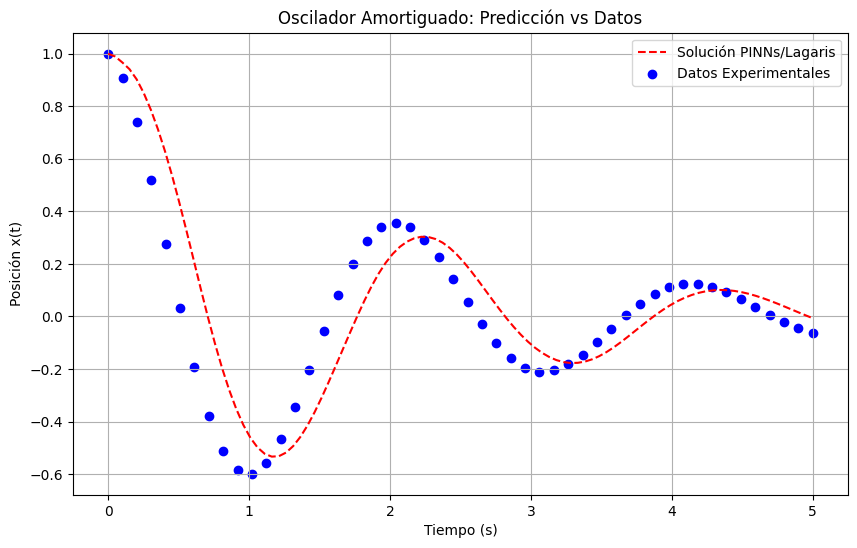

Parámetros inferidos: gamma = 0.9393, k = 8.1078


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Datos simulados experimentales (podrían ser reales en un caso práctico)
t_data = torch.linspace(0, 5, 50).reshape(-1, 1)
x_data = torch.exp(-0.5 * t_data) * torch.cos(3 * t_data)  # Solución simulada con gamma=0.5, k=9

# Definir la red neuronal
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(1, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 1)
        )

    def forward(self, t):
        return self.hidden(t)

# Método de Lagaris para función de prueba
def x_hat(t, nn_model, x0=1.0, v0=0.0):
    # Asegura la condición inicial x(0)=x0, dx/dt(0)=v0
    return x0 + v0 * t + t**2 * nn_model(t)  # t^2 asegura que dx/dt(0)=0

# Configurar datos y modelo
t_values = torch.linspace(0, 5, 100).reshape(-1, 1)
t_values.requires_grad = True  # Para derivadas
model = NeuralNet()

# Parámetros físicos a inferir (inicializados arbitrariamente)
gamma = torch.nn.Parameter(torch.tensor([1.0]))
k = torch.nn.Parameter(torch.tensor([1.0]))

# Optimizador (incluye parámetros de la red y parámetros físicos)
optimizer = optim.Adam(list(model.parameters()) + [gamma, k], lr=0.01)
loss_fn = nn.MSELoss()

# Entrenamiento
epochs = 40000
for epoch in range(epochs):
    optimizer.zero_grad()

    # Predicción
    x_pred = x_hat(t_values, model)

    # Derivadas
    dx_dt = torch.autograd.grad(x_pred.sum(), t_values, create_graph=True)[0]
    d2x_dt2 = torch.autograd.grad(dx_dt.sum(), t_values, create_graph=True)[0]

    # Ecuación diferencial: d²x/dt² + gamma*dx/dt + k*x = 0
    physics_loss = loss_fn(d2x_dt2 + gamma * dx_dt + k * x_pred, torch.zeros_like(d2x_dt2))

    # Pérdida de datos (comparar con datos experimentales)
    x_pred_data = x_hat(t_data, model)
    data_loss = loss_fn(x_pred_data, x_data)

    # Pérdida total (combinación de física y datos)
    loss = 0.1 * physics_loss + data_loss

    # Actualizar parámetros
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}, gamma: {gamma.item():.4f}, k: {k.item():.4f}")

# Resultados
t_np = t_values.detach().numpy().flatten()
x_nn = x_hat(t_values, model).detach().numpy().flatten()
t_data_np = t_data.numpy().flatten()
x_data_np = x_data.numpy().flatten()

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(t_np, x_nn, label="Solución PINNs/Lagaris", color="red", linestyle="dashed")
plt.scatter(t_data_np, x_data_np, label="Datos Experimentales", color="blue")
plt.xlabel("Tiempo (s)")
plt.ylabel("Posición x(t)")
plt.legend()
plt.title("Oscilador Amortiguado: Predicción vs Datos")
plt.grid(True)
plt.show()

# Imprimir parámetros inferidos
print(f"Parámetros inferidos: gamma = {gamma.item():.4f}, k = {k.item():.4f}")